# Building gradients

This section describes how to generate macroscale gradient mapping from the output matrices of micapipe. The matrices are the same as in the [`Main output matrices`](https://micapipe.readthedocs.io/en/latest/pages/04.matrices/index.html) tutorial.

For this tutorial we will map each modality of a single subject using `brainspace`, a `python` based library.

For further information about how to use `brainspace` and macroscale gradient mapping and analysis of neuroimaging and connectome level data visit their documentation here: [BrainSpace documentation](https://brainspace.readthedocs.io/en/latest/index.html).

Additionally the libraries `os`, `numpy`, `nibabel` and `matplotlib` will be used.

As in previous examples, we will use the subject `HC001`, session `01` from the MICs dataset, and all paths will be relative to the subject directory or `out/micapipe_v0.2.0/sub-HC001_ses01/` and the atlas `schaefer-400`.

In this tutorial we will only plot the first 3 components of the diffusion map embedding (aka gradients).

For further references about **diffusion map embedding** check:
> - Coifman & Lafon. Diffusion maps. Applied and computational harmonic analysis. 2006 Jul 1;21(1):5-30. https://doi.org/10.1016/j.acha.2006.04.006
> - Vos de Wael, Benkarim, et al. BrainSpace: a toolbox for the analysis of macroscale gradients in neuroimaging and connectomics datasets. Commun Biol 3, 103 (2020). https://doi.org/10.1038/s42003-020-0794-7

### Set the enviroment

The first step is to set the python environment and all the variables relative to the subject you're interested to visualize.


In [1]:
# Set the environment
import os
import numpy as np
import nibabel as nib
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt

# Set the working directory to the 'out' directory
out='/data_/mica3/BIDS_MICs/derivatives'
os.chdir(out)     # <<<<<<<<<<<< CHANGE THIS PATH

# This variable will be different for each subject
sub='HC001' # <<<<<<<<<<<< CHANGE THIS SUBJECT's ID
ses='01'    # <<<<<<<<<<<< CHANGE THIS SUBJECT's SESSION
subjectID=f'sub-{sub}_ses-{ses}'           
subjectDir=f'micapipe_v0.2.0/sub-{sub}/ses-{ses}' 

# Here we define the atlas 
atlas='schaefer-400' # <<<<<<<<<<<< CHANGE THIS ATLAS

# Path to MICAPIPE from global enviroment
micapipe=os.popen("echo $MICAPIPE").read()[:-1] # <<<<<<<<<<<< CHANGE THIS PATH

### Load the surfaces

In [2]:
# Load fsLR-32k
f32k_lh, f32k_rh = load_conte69()

# Load fsaverage5
fs5_lh = read_surface('freesurfer/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface('freesurfer/fsaverage5/surf/rh.pial', itype='fs')

# Load annotation file in fsaverage5
annot_lh_fs5= nib.freesurfer.read_annot(micapipe + '/parcellations/lh.'+atlas+'_mics.annot')
Ndim = max(np.unique(annot_lh_fs5[0]))
annot_rh_fs5= nib.freesurfer.read_annot(micapipe + '/parcellations/rh.'+atlas+'_mics.annot')[0]+Ndim

# replace with 0 the medial wall of the right labels
annot_rh_fs5 = np.where(annot_rh_fs5==Ndim, 0, annot_rh_fs5) 

# fsaverage5 labels
labels_fs5 = np.concatenate((annot_lh_fs5[0], annot_rh_fs5), axis=0)

# Read label for fsLR-32k
labels_f32k = np.loadtxt(open(f'{micapipe}/parcellations/{atlas}_conte69.csv'), dtype=int)


# Building gradients from atlas based connectomes

# Functional gradients
## Load and slice the functional matrix

In [3]:
# acquisitions
func_acq='desc-se_task-rest_acq-AP_bold'
cnt_fs = subjectDir + f'/func/{func_acq}/surf/' + subjectID + '_surf-fsLR-32k_atlas-' + atlas + '_desc-FC.shape.gii'

# Load the cortical connectome
mtx_fs = nib.load(cnt_fs).darrays[0].data

# slice the matrix to keep only the cortical ROIs
FC = mtx_fs[49:, 49:]
#FC = np.delete(np.delete(FC, Ndim, axis=0), Ndim, axis=1)

# Fischer transformation
FCz = np.arctanh(FC)

# replace inf with 0
FCz[~np.isfinite(FCz)] = 0

# Mirror the matrix
FCz = np.triu(FCz,1)+FCz.T

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_28723/2521866638.py:13: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(FC)


## Calculate the functional gradients

In [4]:
# Number of gradients
N = 10

# Calculate the gradients
gm = GradientMaps(n_components=N, random_state=None, approach='dm', kernel='normalized_angle')
gm.fit(FCz, sparsity=0.85)

GradientMaps(kernel='normalized_angle')

## Plot the functional gradients

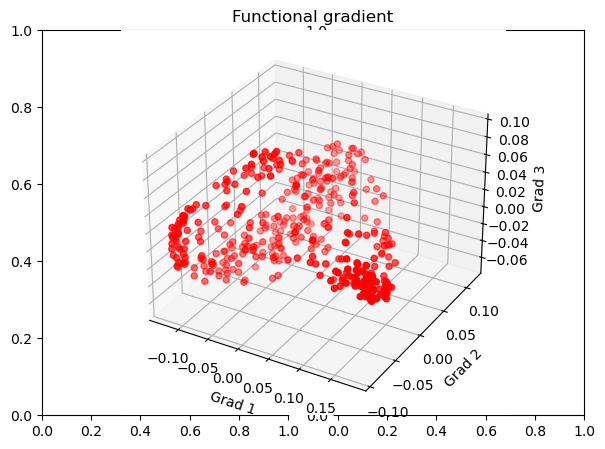

In [5]:
# Plot the gradients
g1=gm.gradients_[:, 0]
g2=gm.gradients_[:, 1]
g3=gm.gradients_[:, 2]

# Creating figure
fig = plt.subplots(1, 2, figsize = (7, 5))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(g1, g2, g3, color = 'red')
plt.title("Functional gradient")
ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')
 
# show plot
plt.show()

## Functional gradients to fsaverage5 surface

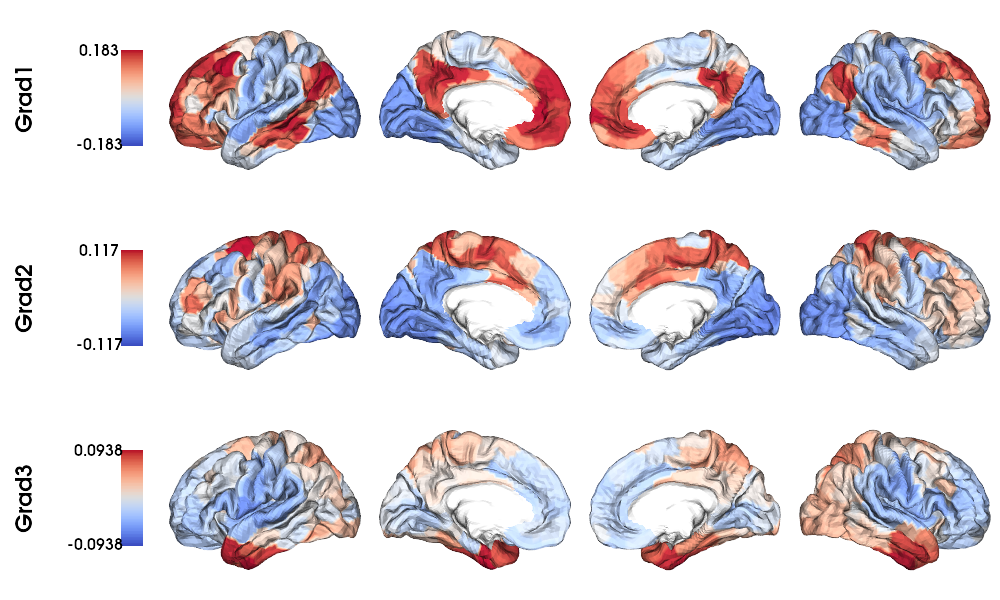

In [6]:
# Mask of the medial wall on fsaverage 5
mask_fs5 = labels_fs5 != 0

# Map gradients to original parcels
grad = [None] * 3
for i, g in enumerate(gm.gradients_.T[0:3,:]):
    grad[i] = map_to_labels(g, labels_fs5,  fill=np.nan, mask=mask_fs5)
    
# Plot Gradients RdYlBu
plot_hemispheres(fs5_lh, fs5_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':['Grad1', 'Grad2','Grad3']}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1), color_range = 'sym' )

## Functional gradients to fsLR-32k surface

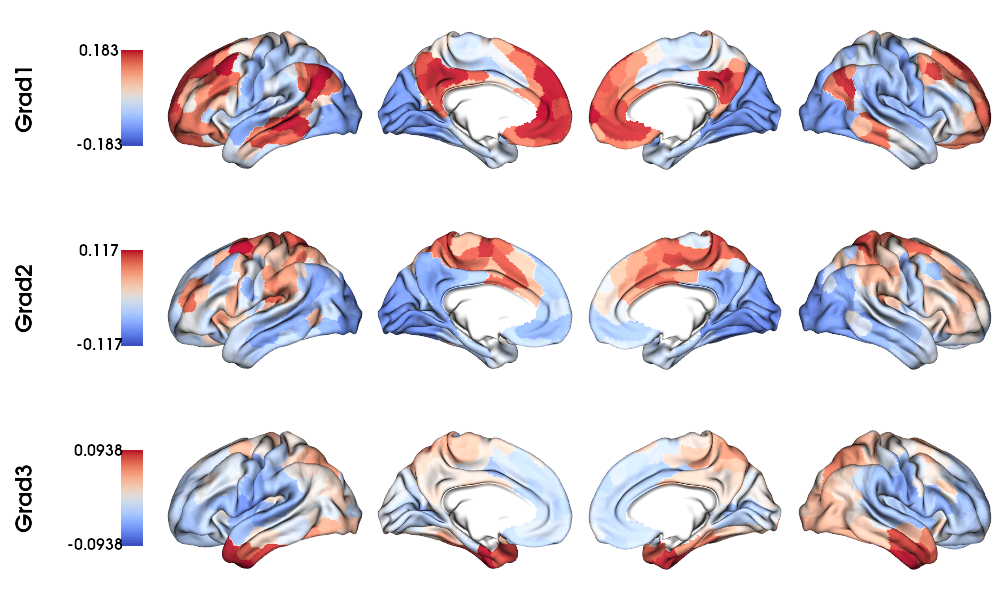

In [7]:
# mask of the medial wall
mask_f32k = labels_f32k != 0

# Map gradients to original parcels
grad = [None] * 3
for i, g in enumerate(gm.gradients_.T[0:3,:]):
    grad[i] = map_to_labels(g, labels_f32k, fill=np.nan, mask=mask_f32k)

# Plot Gradients coolwarm
plot_hemispheres(f32k_lh, f32k_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':['Grad1', 'Grad2','Grad3']}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1), color_range = 'sym')

# Structural gradients
## Load and slice the structural matrix

In [8]:
# Set the path to the the structural cortical connectome
cnt_sc_cor = subjectDir + '/dwi/connectomes/' + subjectID + '_space-dwi_atlas-' + atlas + '_desc-iFOD2-40M-SIFT2_full-connectome.shape.gii'

# Load the cortical connectome
mtx_sc = nib.load(cnt_sc_cor).darrays[0].data

# Fill the lower triangle of the matrix
mtx_sc = np.log(np.triu(mtx_sc,1)+mtx_sc.T)
mtx_sc[np.isneginf(mtx_sc)] = 0

# Slice the connectome to use only cortical nodes
SC = mtx_sc[49:, 49:]
SC = np.delete(np.delete(SC, 200, axis=0), 200, axis=1)

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_28723/1201650669.py:8: RuntimeWarning: divide by zero encountered in log
  mtx_sc = np.log(np.triu(mtx_sc,1)+mtx_sc.T)


## Calculate the structural gradients

In [9]:
# SC Left hemi
gm_SC_L = GradientMaps(n_components=N, random_state=None, approach='dm', kernel='normalized_angle')
gm_SC_L.fit(SC[0:Ndim, 0:Ndim], sparsity=0.9)

# SC Right hemi
gm_SC_R = GradientMaps(n_components=N, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
gm_SC_R.fit(SC[Ndim:Ndim*2, Ndim:Ndim*2], sparsity=0.9, reference=gm_SC_L.gradients_)

GradientMaps(alignment='procrustes', kernel='normalized_angle')

## Plot the structural gradients

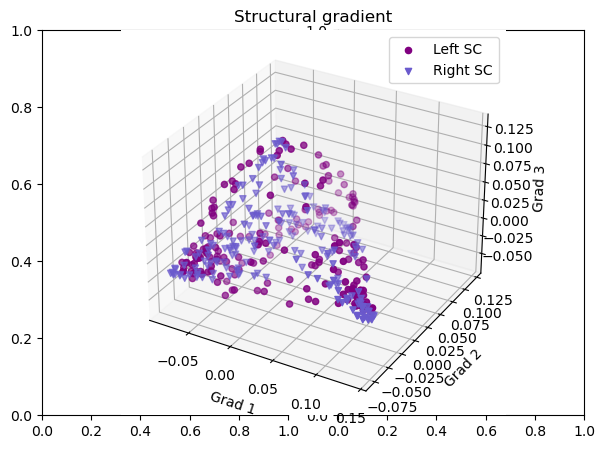

In [10]:
# plot the left gradients
g1=gm_SC_L.gradients_[:, 0]
g2=gm_SC_L.gradients_[:, 1]
g3=gm_SC_L.gradients_[:, 2]
# plot the right gradients
g1R=gm_SC_R.aligned_[:, 0]
g2R=gm_SC_R.aligned_[:, 1]
g3R=gm_SC_R.aligned_[:, 2]

# Creating figure
fig = plt.subplots(1, 2, figsize = (7, 5))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(g1, g2, g3, color = 'purple')
ax.scatter3D(g1R, g2R, g3R, color = 'slateblue', marker='v')
plt.title("Structural gradient")
ax.legend(['Left SC', 'Right SC'])
ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')
 
# show plot
plt.show()

## Structural gradients to fsLR-32k surface

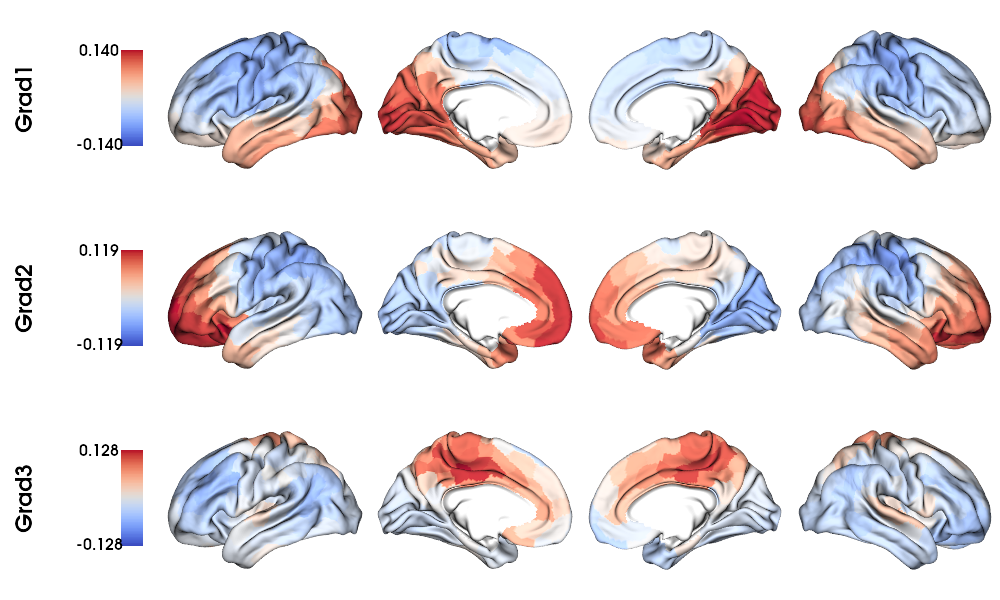

In [11]:
# Left and right gradients concatenated
SC_gradients = np.concatenate((gm_SC_L.gradients_, gm_SC_R.aligned_), axis=0)

# Map gradients to original parcels
grad = [None] * 3
for i, g in enumerate(SC_gradients.T[0:3,:]):
    grad[i] = map_to_labels(g, labels_f32k, fill=np.nan, mask=mask_f32k)

# Plot Gradients
plot_hemispheres(f32k_lh, f32k_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':['Grad1', 'Grad2','Grad3']}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1), color_range = 'sym' )

# MPC gradients
## Load and slice the MPC matrix

In [12]:
# Set the path to the the MPC cortical connectome
mpc_acq='acq-T1map'
cnt_mpc = subjectDir + f'/mpc/{mpc_acq}/' + subjectID + '_atlas-' + atlas + '_desc-MPC.shape.gii'

# Load the cortical connectome
mtx_mpc = nib.load(cnt_mpc).darrays[0].data

# Fill the lower triangle of the matrix
MPC = np.triu(mtx_mpc,1)+mtx_mpc.T

# Renove the medial wall
MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
MPC = np.delete(np.delete(MPC, 200, axis=0), 200, axis=1)

## Calculate the MPC gradients

In [13]:
# Calculate the gradients
gm = GradientMaps(n_components=N, random_state=None, approach='dm', kernel='normalized_angle')
gm.fit(MPC, sparsity=0)

GradientMaps(kernel='normalized_angle')

## Plot the MPC gradients

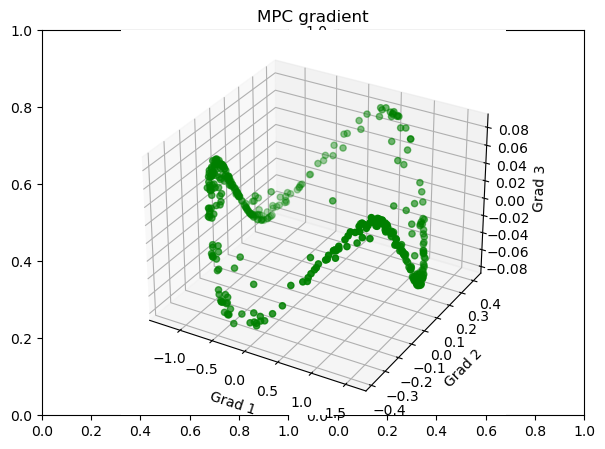

In [14]:
# Plot the gradients
g1=gm.gradients_[:, 0]
g2=gm.gradients_[:, 1]
g3=gm.gradients_[:, 2]

# Creating figure
fig = plt.subplots(1, 2, figsize = (7, 5))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(g1, g2, g3, color = 'green')
plt.title("MPC gradient")
ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')
 
# show plot
plt.show()

## MPC gradients to fsLR-32k surface

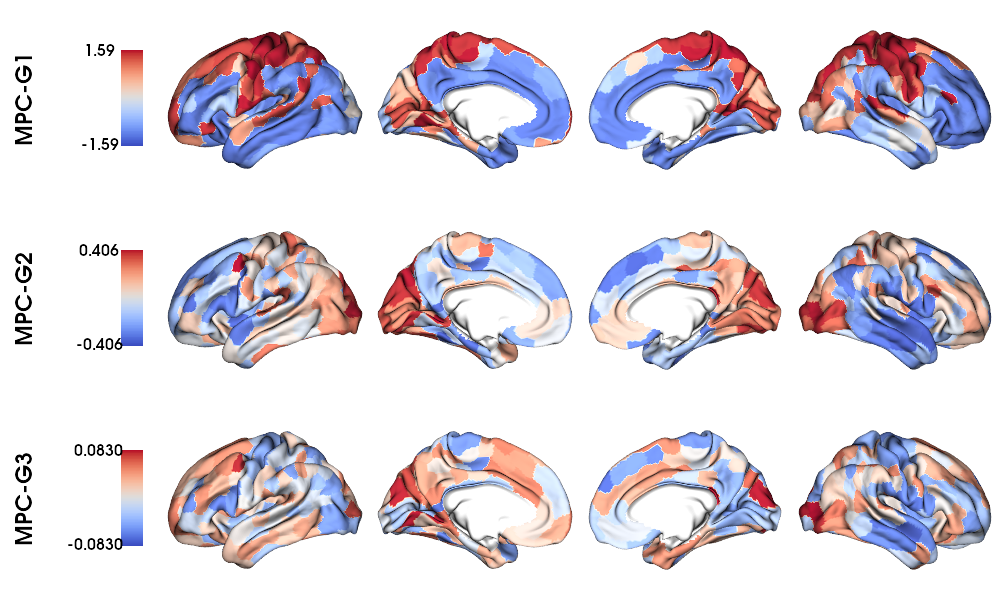

In [15]:
# Map gradients to original parcels
grad = [None] * 3
for i, g in enumerate(gm.gradients_.T[0:3,:]):
    grad[i] = map_to_labels(g, labels_f32k, fill=np.nan, mask=mask_f32k)

# Plot Gradients
plot_hemispheres(f32k_lh, f32k_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':['MPC-G1', 'MPC-G2','MPC-G3']}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1), color_range = 'sym' )

# Geodesic distance
## Load and slice the GD matrix

In [16]:
# Set the path to the the geodesic distance connectome
cnt_gd = subjectDir + '/dist/' + subjectID + '_atlas-' + atlas + '_GD.shape.gii'

# Load the cortical connectome
mtx_gd = nib.load(cnt_gd).darrays[0].data

# Remove the Mediall Wall
mtx_gd = np.delete(np.delete(mtx_gd, 0, axis=0), 0, axis=1)
GD = np.delete(np.delete(mtx_gd, Ndim, axis=0), Ndim, axis=1)

## Calculate the GD gradients

In [17]:
# GD Left hemi
gm_GD_L = GradientMaps(n_components=N, random_state=None, approach='dm', kernel='normalized_angle')
gm_GD_L.fit(GD[0:Ndim, 0:Ndim], sparsity=0.8)

# GD Right hemi
gm_GD_R = GradientMaps(n_components=N, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
gm_GD_R.fit(GD[Ndim:Ndim*2, Ndim:Ndim*2], sparsity=0.8, reference=gm_GD_L.gradients_)


GradientMaps(alignment='procrustes', kernel='normalized_angle')

## Plot the GD gradients

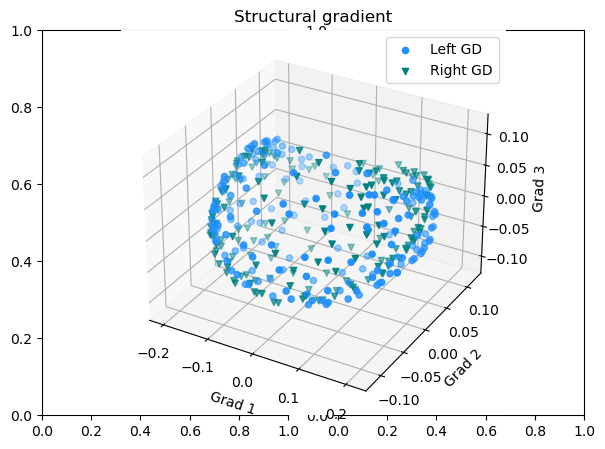

In [18]:
# plot the gradients
g1=gm_GD_L.gradients_[:, 0]
g2=gm_GD_L.gradients_[:, 1]
g3=gm_GD_L.gradients_[:, 2]
# plot the gradients
g1R=gm_GD_R.aligned_[:, 0]
g2R=gm_GD_R.aligned_[:, 1]
g3R=gm_GD_R.aligned_[:, 2]

# Creating figure
fig = plt.subplots(1, 2, figsize = (7, 5))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(g1, g2, g3, color = 'dodgerblue')
ax.scatter3D(g1R, g2R, g3R, color = 'teal', marker='v')
plt.title("Structural gradient")
ax.legend(['Left GD', 'Right GD'])
ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3')
 
# show plot
plt.show()

## GD gradients to fsLR-32k surface

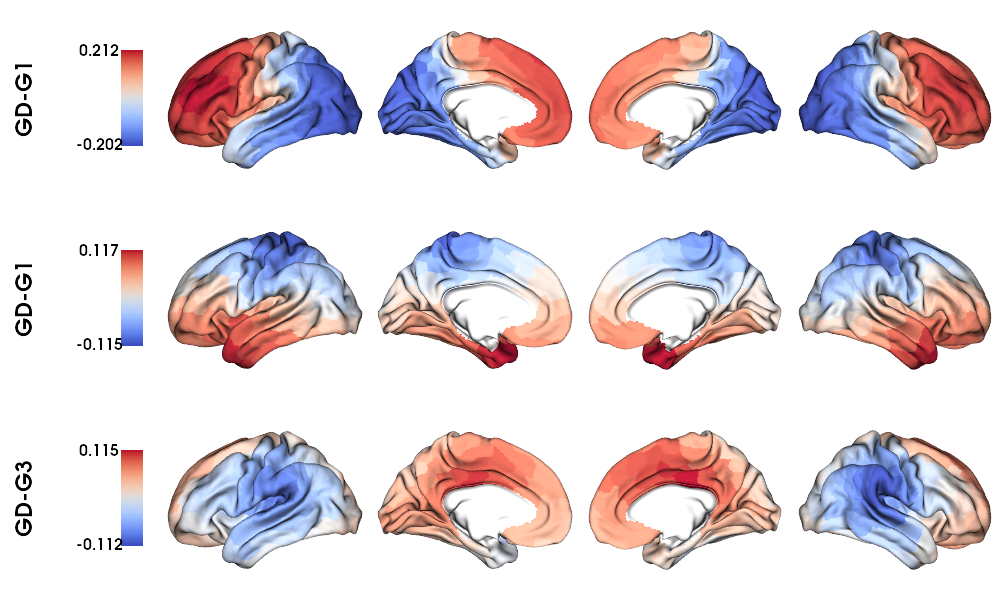

In [19]:
# Left and right gradients concatenated
GD_gradients = np.concatenate((gm_GD_L.gradients_, gm_GD_R.aligned_), axis=0)

# Map gradients to original parcels
grad = [None] * 3
for i, g in enumerate(GD_gradients.T[0:3,:]):
    grad[i] = map_to_labels(g, labels_f32k, fill=np.nan, mask=mask_f32k)

# Plot Gradients
plot_hemispheres(f32k_lh, f32k_rh, array_name=grad, size=(1000, 600), cmap='coolwarm',
                 embed_nb=True,  label_text={'left':['GD-G1', 'GD-G1','GD-G3']}, color_bar='left', 
                 zoom=1.25, nan_color=(1, 1, 1, 1))